In [54]:
import numpy as np

In [55]:
np.warnings.filterwarnings('ignore')

In [56]:
# %load utils.py
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline


############### Data Helpers ############### 
def load_data(csv_path):
    data = pd.read_csv(csv_path)
    data.rename(index=str,columns={ 'Unnamed: 0': 'Company'}, inplace=True)
    data.set_index('Company', inplace=True)
    data.columns = pd.to_datetime(data.columns)
    return data

def select_subset(dataframe,n_companies, n_days,total_companies):
    np.random.seed(47)
    rand_idx = np.random.choice(total_companies,n_companies, replace=False)
    subset = dataframe.iloc[rand_idx]
    return subset.iloc[:,:n_days]


############### Figures and Plotting ############### 
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")

def save_fig(fig_id, prefix='', tight_layout=False, fig_extension="png", resolution=300):
    
    dir_path = os.path.join(IMAGES_PATH, prefix)
    if not os.path.isdir(dir_path):
        os.makedirs(dir_path)
    
    path = os.path.join(dir_path, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)    
    

def plot_clustering_results(X,n, labels, plot_title):
     for label in np.unique(labels):
        X.iloc[labels == label].T.plot(figsize=(16,8),grid=True)
        plt.title(plot_title)
        plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


def save_clustering_results(X,n,labels, folder, plot_title, data_size='500x453'):
    current_path = os.path.join(folder,'{}_{}_clusters'.format(data_size,n))
    scaled_path = os.path.join(current_path, 'scaled')
    unscaled_path = os.path.join(current_path, 'unscaled')

    
    for label in np.unique(labels):
        X.iloc[labels == label].T.plot(figsize=(16,8),grid=True)
        plt.title(plot_title)
        plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
        save_fig(fig_id='clust_{}_{}'.format(label, data_size), prefix=unscaled_path, tight_layout=False, resolution=100)
        
        
    value_range = get_value_range(X)
    for label in np.unique(labels):
        X.iloc[labels == label].T.plot(figsize=(16,8),ylim=value_range,grid=True)
        plt.title(plot_title)
        plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
        save_fig(fig_id='clust_{}_{}'.format(label,data_size), prefix=scaled_path, tight_layout=False, resolution=100)
        
          
    clustered_df = pd.DataFrame(index=X.index, data=labels, columns=['Cluster'])
    clustered_df.index.set_names('company')
    clustered_df.to_csv(os.path.join(IMAGES_PATH, current_path + '/labels.csv'))

    
    
def get_value_range(dataframe):
    minValue = dataframe.T.describe().loc['min'].min()
    maxValue = dataframe.T.describe().loc['max'].max()
    return (minValue, maxValue)
    

############### Validation Helpers ############### 

from sklearn.preprocessing import MinMaxScaler
import warnings

def scale_scores(score_df):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        scaler = MinMaxScaler()
        scaled_df = score_df.copy()
        scaled_df[scaled_df.columns] = scaler.fit_transform(score_df)
        return scaled_df

def plot_scores(score_df):
    scaled_df = scaled_scores(score_df)
    ax = scaled_df.plot(figsize=(16,8), x_compat=True, grid=True)
    ax.xaxis.set_major_locator(plt.MaxNLocator(scaled_df.index.max()))

def calc_combined_index(score_df):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        scaler = MinMaxScaler()
        scaled_df = score_df.copy()
        scaled_df[scaled_df.columns] = scaler.fit_transform(scaled_df)

        return scaled_df.calinski + scaled_df.silhuette + ( -1* scaled_df.davis)


In [57]:
from ipynb.fs.defs.PortfolioSelection import create_portfolio

Stock Prices

In [58]:
snp500 = pd.read_csv('../datasets/sp500/sp500.csv', index_col='Date')
snp500.index= pd.to_datetime(snp500.index)

snp500_validation = pd.read_csv('../datasets/sp500/sp500validation.csv', index_col='Date')
snp500_validation.index= pd.to_datetime(snp500_validation.index)

In [59]:
ipc_df = load_data('../initial_pct_change.csv')

In [60]:
ipc_df_100 = select_subset(ipc_df, 100, 453, ipc_df.shape[0])

In [61]:
snp500_validation.tail()

MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-02-25  210.580002  76.860001  80.290001  352.890015  161.669998   
2019-02-26  209.380005  76.750000  80.510002  342.869995  161.339996   
2019-02-27  209.029999  77.230003  79.410004  336.170013  160.630005   
2019-02-28  207.389999  77.620003  79.239998  334.500000  161.380005   
2019-03-01  207.500000  78.339996  79.870003  348.834991  163.869995   

                 ATVI        ADBE        AMD         AAP        AES  \
Date                                                                  
2019-02-25  41.959999  258.619995  24.709999  157.710007  17.330000   
2019-02-26  42.080002  261.220001  24.209999  162.919998  17.290001   
2019-02-27  41.790001  262.899994  23.480000  158.300003  17.160000   
2019-02-28  42.139999  262.500000  23.530001  161.779999  17.230000   
2019-03-01  43.012501  263.864990  23.579901  159.845001  17.465000   

              ...            WLTW        WYNN        XEL        XRX  \
Date          ...                                                     
2019-02-25    ...      171.449997  129.199997  54.709999  31.480000   
2019-02-26    ...      170.380005  130.449997  54.470001  31.469999   
2019-02-27    ...      170.539993  127.709999  54.389999  31.420000   
2019-02-28    ...      172.020004  126.540001  54.860001  30.900000   
2019-03-01    ...      172.134995  125.059998  54.525002  31.360001   

                  XLNX        XYL        YUM         ZBH       ZION        ZTS  
Date                                                                            
2019-02-25  124.040001  75.260002  93.500000  123.900002  50.990002  94.389999  
2019-02-26  122.779999  75.370003  93.360001  123.360001  50.419998  93.489998  
2019-02-27  123.269997  76.300003  93.110001  124.489998  51.080002  93.800003  
2019-02-28  125.300003  75.550003  94.500000  124.120003  51.099998  94.230003  
2019-03-01  126.260002  76.220001  95.099998  125.540001  51.029999  95.309998  

[5 rows x 498 columns]

# Clustering

In [62]:
from sklearn import metrics
from sklearn.cluster import *

## KMeans

In [68]:
X = ipc_df.copy()
data_size = '500x453'

# X = ipc_df_100.copy()
# data_size = '100x453'

In [69]:
min_clusters = 5
max_clusters = 100 if len(X.index) > 100 else len(X.index) -1

kmeans_score = pd.DataFrame(index=np.arange(min_clusters, max_clusters), columns=['silhuette', 'calinski', 'davis'])
kmeans_score.index.name = 'n_clusters'


for n in range(min_clusters, max_clusters):
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X)
    labels = kmeans.labels_

    sil = metrics.silhouette_score(X,labels)
    calinski = metrics.calinski_harabaz_score(X,labels)
    davis = metrics.davies_bouldin_score(X,labels);
        
    kmeans_score.loc[n] = [sil, calinski, davis]

Text(0.5, 1.0, 'Scores 500x453, KMeans')

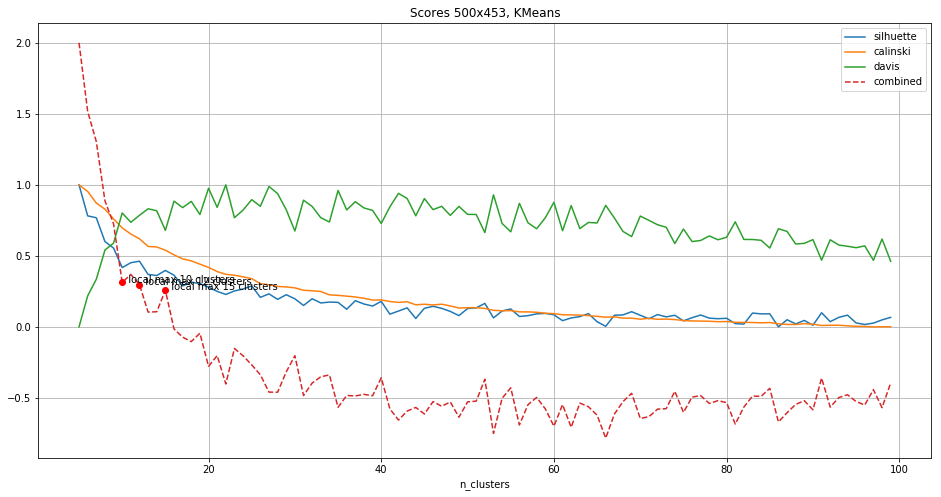

In [70]:
scale_scores(kmeans_score).plot()
comb_score = calc_combined_index(kmeans_score)
comb_score.plot(figsize=(16,8), x_compat=True, grid=True, label='combined', legend=True, ls='--')

# n = min_clusters
# while n < max_clusters:
#     n_with_max_score= comb_score.loc[n:n+5].idxmax()
    
#     plt.plot(n_with_max_score, comb_score.loc[n_with_max_score], 'ro')
#     plt.annotate('  local max {} clusters'.format(n_with_max_score),
#                  xy=(n_with_max_score, comb_score.loc[n_with_max_score]))
    
#     n = n+5

hand_picked_choise = [10,12,15]
for n in hand_picked_choise:    
    plt.plot(n, comb_score.loc[n], 'ro')
    plt.annotate('  local max {} clusters'.format(n),
                 xy=(n, comb_score.loc[n]))
    
plt.title('Scores {}, KMeans'.format(data_size))
save_fig('scores_{}_kmeans'.format(linkage), prefix='KMeans')

In [ ]:
print('Scores {} KMeans'.format(data_size))
print()
print(kmeans_score.loc[hand_picked_choise])
print()
print()
print('normalized')
print(scale_scores(kmeans_score).loc[hand_picked_choise])

In [ ]:
for n in hand_picked_choise:
    kmeans = KMeans(n_clusters=n)
    labels = kmeans.fit_predict(X)
    folder = 'KMeans'
    save_clustering_results(X,
                            n,
                            labels,
                            folder,
                            'KMeans {} Euclidean Distance'.format(data_size),
                            data_size=data_size
                           )


In [ ]:
for n in hand_picked_choise:
    kmeans = KMeans(n_clusters=n)
    labels = kmeans.fit_predict(X)
    
    clustered_df = pd.DataFrame(index=X.index, data=labels, columns=['Cluster'])
    clustered_df.index.set_names('company')
    
    validation_set = snp500_validation[snp500_validation.columns.intersection(clustered_df.index)]
    allocation, stats =  create_portfolio(snp500,validation_set , clustered_df)
    
    folder = os.path.join('KMeans','{}_{}_clusters'.format(data_size,n))
    save_fig(fig_id='portfolio_{}_clusters_{}'.format(n,data_size), prefix=folder, tight_layout=False, resolution=300)
    
    stats['Num of Portfolio Companies'] = [(allocation['Allocation'] > 0).sum(), len(validation_set.columns)]
    stats['Algorithm'] = [
        'KMeans',
        'Equal Allocation of S&P500'
    ]
    stats['Distance Metric'] = ['Euclidean', np.nan]
    stats['Data Size'] = data_size
    stats['Number of clusters'] = [n, np.nan]
    
    allocation.to_csv(os.path.join(IMAGES_PATH,folder, 'portfolio-allocation.csv'))
    stats.to_csv(os.path.join(IMAGES_PATH,folder, 'portfolio-stats.csv'))

## KMediods

In [ ]:
import random
from past.builtins import xrange
from sklearn.metrics.pairwise import euclidean_distances


def transform_labels(labels_by_clusters, X):
    labels = np.empty_like(X.index)
    for label in labels_by_clusters:
        labels[labels_by_clusters[label]] = label
        
    return labels

def kMedoids(D, k, tmax=100):
    # determine dimensions of distance matrix D
    m, n = D.shape

    if k > n:
        raise Exception('too many medoids')

    # find a set of valid initial cluster medoid indices since we
    # can't seed different clusters with two points at the same location
    valid_medoid_inds = set(range(n))
    invalid_medoid_inds = set([])
    rs,cs = np.where(D==0)
    # the rows, cols must be shuffled because we will keep the first duplicate below
    index_shuf = list(range(len(rs)))
    np.random.shuffle(index_shuf)
    rs = rs[index_shuf]
    cs = cs[index_shuf]
    for r,c in zip(rs,cs):
        # if there are two points with a distance of 0...
        # keep the first one for cluster init
        if r < c and r not in invalid_medoid_inds:
            invalid_medoid_inds.add(c)
    valid_medoid_inds = list(valid_medoid_inds - invalid_medoid_inds)

    if k > len(valid_medoid_inds):
        raise Exception('too many medoids (after removing {} duplicate points)'.format(
            len(invalid_medoid_inds)))

    # randomly initialize an array of k medoid indices
    M = np.array(valid_medoid_inds)
    np.random.shuffle(M)
    M = np.sort(M[:k])

    # create a copy of the array of medoid indices
    Mnew = np.copy(M)

    # initialize a dictionary to represent clusters
    C = {}
    for t in xrange(tmax):
        # determine clusters, i. e. arrays of data indices
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]
        # update cluster medoids
        for kappa in range(k):
            J = np.mean(D[np.ix_(C[kappa],C[kappa])],axis=1)
            j = np.argmin(J)
            Mnew[kappa] = C[kappa][j]
        np.sort(Mnew)
        # check for convergence
        if np.array_equal(M, Mnew):
            break
        M = np.copy(Mnew)
    else:
        # final update of cluster memberships
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]

    # return results
    return M, C

### Fine Tuning

In [ ]:
X = ipc_df.copy()
data_size = '500x453'

# X = ipc_df_100.copy()
# data_size = '100x453'

In [ ]:
curr_dist = euclidean_distances(X)

In [ ]:
min_clusters = 5
max_clusters = 100 if len(X.index) > 100 else len(X.index) -1

kmediods_score = pd.DataFrame(index=np.arange(min_clusters, max_clusters), columns=['silhuette', 'calinski', 'davis'])
kmediods_score.index.name = 'n_clusters'

In [ ]:
for n in range(min_clusters, max_clusters):
    _, C = kMedoids(curr_dist, n)
    labels = transform_labels(C,X)

    sil = metrics.silhouette_score(X,labels)
    calinski = metrics.calinski_harabaz_score(X,labels)
    davis = metrics.davies_bouldin_score(X,labels);
        
    kmediods_score.loc[n] = [sil, calinski, davis]

In [ ]:
scale_scores(kmediods_score).plot(alpha=0.5)
comb_score = calc_combined_index(kmediods_score)
comb_score.plot(figsize=(16,8), x_compat=True, grid=True, label='combined', legend=True, ls='--')

# n = min_clusters
# while n < max_clusters:
#     n_with_max_score= comb_score.loc[n:n+5].idxmax()
    
#     plt.plot(n_with_max_score, comb_score.loc[n_with_max_score], 'ro')
#     plt.annotate('  local max {} clusters'.format(n_with_max_score),
#                  xy=(n_with_max_score, comb_score.loc[n_with_max_score]))
    
#     n = n+5

hand_picked_choise = [11,17,26,29,41]
for n in hand_picked_choise:    
    plt.plot(n, comb_score.loc[n], 'ro')
    plt.annotate('  {}'.format(n),
                 xy=(n, comb_score.loc[n]))
    
plt.title('Scores {}, Kmediods Euclidean Distance'.format(data_size))
save_fig('scores_{}_kmediods_euclidean'.format(data_size), prefix='KMediods/Euclidean/')



In [ ]:
print('Scores {} KMediods Pearson Correlation'.format(data_size))
print()
print(kmediods_score.loc[hand_picked_choise])
print()
print()
print('normalized')
print(scale_scores(kmediods_score).loc[hand_picked_choise])

In [ ]:
for n in hand_picked_choise:
    M, C = kMedoids(curr_dist, n)
    labels = transform_labels(C,X)
    save_clustering_results(X,
                            n,
                            labels,
                            'KMediods/Euclidean',
                            'KMediods {}'.format(data_size),
                            data_size=data_size
                           )

In [ ]:
for n in hand_picked_choise:
    M, C = kMedoids(curr_dist, n)
    labels = transform_labels(C,X)
   
    clustered_df = pd.DataFrame(index=X.index, data=labels, columns=['Cluster'])
    clustered_df.index.set_names('company')
    
    validation_set = snp500_validation[snp500_validation.columns.intersection(clustered_df.index)]
    allocation, stats =  create_portfolio(snp500, validation_set, clustered_df)
    
    folder = os.path.join('KMediods', 'Euclidean','{}_{}_clusters'.format(data_size,n))
    save_fig(fig_id='portfolio_{}_clusters_{}'.format(n,data_size), prefix=folder, tight_layout=False, resolution=300)
    
    stats['Num of Portfolio Companies'] = [(allocation['Allocation'] > 0).sum(), validation_set.shape[1]]
    stats['Algorithm'] = [
        'KMediods',
        'Equal Allocation of S&P500'
    ]
    stats['Distance Metric'] = ['Euclidean', np.nan]
    stats['Data Size'] = data_size
    stats['Number of clusters'] = [n, np.nan]
    
    allocation.to_csv(os.path.join(IMAGES_PATH,folder, 'portfolio-allocation.csv'))
    stats.to_csv(os.path.join(IMAGES_PATH,folder, 'portfolio-stats.csv'))
    

### Mean Shift

In [ ]:
# X = select_subset(ipc_df, 497, 453, ipc_df.shape[0])
X = ipc_df.copy()
data_size = '500x453'

# X = ipc_df_100.copy()
# data_size = '100x453'

In [ ]:
bandwidths = np.arange(1.9,5,0.1)
mshift_score = pd.DataFrame(columns=['silhuette', 'calinski', 'davis','bandwidth'])
mshift_score.index.name = 'n_clusters'

for bandwidth in bandwidths:
    meanshift = MeanShift(bandwidth=bandwidth)
    meanshift.fit(X)
    labels = meanshift.labels_
    
    n_clusters = len(np.unique(labels))
    
    try:
        sil = metrics.silhouette_score(X,labels)
        calinski = metrics.calinski_harabaz_score(X,labels)
        davis = metrics.davies_bouldin_score(X,labels);

        if n_clusters not in mshift_score.index or sil > mshift_score.loc[n_clusters]['silhuette']:
            mshift_score.loc[n_clusters] = [sil, calinski, davis, bandwidth]
    except:
        break

In [ ]:
mshift_score.sort_index(inplace=True)

In [ ]:
mshift_indices = mshift_score[['silhuette', 'calinski', 'davis']]
scale_scores(mshift_indices).plot(alpha=0.5)
comb_score = calc_combined_index(mshift_indices)
comb_score.plot(figsize=(16,8), x_compat=True, grid=True, label='combined', legend=True, ls='--')


for idx,n in enumerate(mshift_indices.index.values):

    n_with_max_score= comb_score.loc[mshift_indices.index.values[idx:idx+5]].idxmax()

    plt.plot(n_with_max_score, comb_score.loc[n_with_max_score], 'ro')
    plt.annotate(' {}'.format(n_with_max_score),
                 xy=(n_with_max_score, comb_score.loc[n_with_max_score]))



# hand_picked_choise = [10,15,20,29]
# for n in hand_picked_choise:    
#     plt.plot(n, comb_score.loc[n], 'ro')

#     plt.annotate('  {}'.format(n),
#                  xy=(n, comb_score.loc[n]))
    
plt.title('Scores {} Mean Shift'.format(data_size))
# save_fig('scores_{}_mean-shift'.format(data_size), prefix='MeanShift')

In [ ]:
print('Scores 500x453 MeanShift')
mshift_score.loc[hand_picked_choise]

In [ ]:
chosen_bandwidths = [4.1,3.8,2.8,2.5]
# for bandwidth in mshift_score.loc[hand_picked_choise]['bandwidth']:
for bandwidth in chosen_bandwidths:
    
    meanshift = MeanShift(bandwidth=bandwidth)
    labels = meanshift.fit_predict(X)
    n = len(np.unique(labels))
    
    folder = 'MeanShift'
    save_clustering_results(X,
                            n,
                            labels,
                            folder,
                            'MeanShift {} Euclidean Distance'.format(data_size),
                            data_size=data_size
                           )

    clustered_df = pd.DataFrame(index=X.index, data=labels, columns=['Cluster'])
    clustered_df.index.set_names('company')
    
    validation_set = snp500_validation[snp500_validation.columns.intersection(clustered_df.index)]
    allocation, stats =  create_portfolio(snp500,validation_set , clustered_df)
    
    folder = os.path.join('MeanShift','{}_{}_clusters'.format(data_size,n))
    save_fig(fig_id='portfolio_{}_clusters_{}'.format(n,data_size), prefix=folder, tight_layout=False, resolution=300)
    
    stats['Num of Portfolio Companies'] = [(allocation['Allocation'] > 0).sum(), len(validation_set.columns)]
    stats['Algorithm'] = [
        'MeanShift',
        'Equal Allocation of S&P500'
    ]
    stats['Distance Metric'] = ['Euclidean', np.nan]
    stats['Data Size'] = data_size
    stats['Number of clusters'] = [n, np.nan]
    
    allocation.to_csv(os.path.join(IMAGES_PATH,folder, 'portfolio-allocation.csv'))
    stats.to_csv(os.path.join(IMAGES_PATH,folder, 'portfolio-stats.csv'))



### HDBSCAN

In [ ]:
import hdbscan

In [ ]:

# X = ipc_df.copy()
# data_size = '500x453'

X = ipc_df_100.copy()
data_size = '100x453'

In [ ]:
hdb_score = pd.DataFrame(columns=['silhuette', 'calinski', 'davis', 'min_samples', 'min_cluster_size', 'selection_method'])
hdb_score.index.name = 'n_clusters'

cluster_selection_methods = ['eom','leaf']

for selection_method in cluster_selection_methods:
    for min_samples in range(1, 30):
        for min_c_size in range(2, 70):
            hdb = hdbscan.HDBSCAN(min_cluster_size=min_c_size,
                                  min_samples=min_samples,
                                  cluster_selection_method=selection_method
                                 )
            labels  = hdb.fit_predict(X)
            n_clusters = len(np.unique(labels))

            try:
                sil = metrics.silhouette_score(X,labels)
                calinski = metrics.calinski_harabaz_score(X,labels)
                davis = metrics.davies_bouldin_score(X,labels);


                if n_clusters not in hdb_score.index or sil > hdb_score.loc[n_clusters]['silhuette']:
                    hdb_score.loc[n_clusters] = [sil, calinski, davis, min_samples, min_c_size, selection_method]

            except:
                break

In [ ]:
hdb_score.sort_index(inplace=True)

In [ ]:
hdb_score_indices = hdb_score[['silhuette', 'calinski', 'davis']]
scale_scores(hdb_score_indices).plot(alpha=0.5)
comb_score = calc_combined_index(hdb_score_indices)
comb_score.plot(figsize=(16,8), x_compat=True, grid=True, label='combined', legend=True, ls='--')


hand_picked_choise = [4,9,15,20,27,42]
for n in hand_picked_choise:    
    plt.plot(n, comb_score.loc[n], 'ro')

    plt.annotate('  {}'.format(n),
                 xy=(n, comb_score.loc[n]))
    
plt.title('Scores {} HDBSCAN'.format(data_size))
save_fig('scores_{}_hdbscan'.format(data_size), prefix='Hdbscan/Euclidean')

In [ ]:
print('Scores 500x453 HDBSCAN')
hdb_score.loc[hand_picked_choise]

In [ ]:
for index, model in hdb_score.loc[hand_picked_choise].iterrows():
    min_samples= model['min_samples']
    min_cluster_size=model['min_cluster_size']
    selection_method=model['selection_method']
    hdb = hdbscan.HDBSCAN(min_samples=min_samples,
                          min_cluster_size=min_cluster_size, 
                          cluster_selection_method=selection_method,
                          metric='precomputed')
    labels = hdb.fit_predict(X)

    folder = os.path.join('Hdbscan', 'Euclidean')
    n_clusters = len(np.unique(labels))
    save_clustering_results(X,
                            n_clusters, 
                            labels, 
                            folder,
                            'Hdbscan {},  min_samples={}, min_c_size={}, selection_method={}'.format(data_size,min_samples,min_cluster_size,selection_method),
                            data_size=data_size)

In [ ]:
for index, model in hdb_score.loc[hand_picked_choise].iterrows():
    min_samples= model['min_samples']
    min_cluster_size=model['min_cluster_size']
    selection_method=model['selection_method']
    hdb = hdbscan.HDBSCAN(min_samples=min_samples,
                          min_cluster_size=min_cluster_size, 
                          cluster_selection_method=selection_method,
                         )
    labels = hdb.fit_predict(X)
    
      
    clustered_df = pd.DataFrame(index=X.index, data=labels, columns=['Cluster'])
    clustered_df.index.set_names('company')
    
    validation_set = snp500_validation[snp500_validation.columns.intersection(clustered_df.index)]
    allocation, stats =  create_portfolio(snp500,validation_set , clustered_df)
    
    n_clusters = len(np.unique(labels))
   
  
    folder = os.path.join('Hdbscan', 'Euclidean', '{}_{}_clusters'.format(data_size,n_clusters))
    save_fig(fig_id='portfolio_{}_clusters_{}'.format(n_clusters,data_size), prefix=folder, tight_layout=False, resolution=300)
    
    stats['Num of Portfolio Companies'] = [(allocation['Allocation'] > 0).sum(), len(validation_set.columns)]
    stats['Algorithm'] = [
        'HDBSCAN',
        'Equal Allocation of S&P500'
    ]
    stats['Distance Metric'] = ['Euclidean', np.nan]
    stats['Data Size'] = data_size
    stats['Number of clusters'] = [n_clusters, np.nan]
    
    allocation.to_csv(os.path.join(IMAGES_PATH,folder, 'portfolio-allocation.csv'))
    stats.to_csv(os.path.join(IMAGES_PATH,folder, 'portfolio-stats.csv'))

### Agglomerative

#### Complete, Average, Ward Linkage

In [ ]:
X = ipc_df.copy()
data_size = '500x453'

# X = ipc_df_100.copy()
# data_size = '100x453'

# linkage = 'complete'
# linkage = 'average'
linkage = 'ward'

In [ ]:
min_clusters = 4
max_clusters = 100 if len(X.index) > 100 else len(X.index) - 1

ag_score = pd.DataFrame(index=np.arange(min_clusters, max_clusters), columns=['silhuette', 'calinski', 'davis'])
ag_score.index.name = 'n_clusters'

In [ ]:
for n in range(min_clusters, max_clusters):
    ag = AgglomerativeClustering(n_clusters=n, linkage=linkage)
    ag.fit(X)
    
    sil = metrics.silhouette_score(X,ag.labels_)
    calinski = metrics.calinski_harabaz_score(X,ag.labels_)
    davis = metrics.davies_bouldin_score(X, ag.labels_)
    
    ag_score.loc[n] = [sil, calinski, davis]

In [ ]:
scale_scores(ag_score).plot()
comb_score = calc_combined_index(ag_score)
comb_score.plot(figsize=(16,8), x_compat=True, grid=True, label='combined', legend=True, ls='--')


# n = min_clusters
# while n < max_clusters:
#     n_with_max_score= comb_score.loc[n:n+5].idxmax()
    
#     plt.plot(n_with_max_score, comb_score.loc[n_with_max_score], 'ro')
#     plt.annotate('  {}'.format(n_with_max_score),
#                  xy=(n_with_max_score, comb_score.loc[n_with_max_score]))
    
#     n = n+5

handpicked = [11,15,38]
for n in handpicked:
    plt.plot(n, comb_score.loc[n], 'ro')
    plt.annotate('  {}'.format(n),
                 xy=(n, comb_score.loc[n]))
    
plt.title('Scores {}, Agglomerative {} linkage Euclidean distance'.format(data_size,linkage));
save_fig('scores_{}_{}_euclidean'.format(data_size, linkage), prefix='Agglomerative/Euclidean/{}-linkage'.format(linkage))

In [ ]:
print('Scores {} {} linkage'.format(data_size, linkage))
print()
print(ag_score.loc[handpicked])
ag_score.loc[handpicked].to_csv( IMAGES_PATH+'/Agglomerative/Euclidean/{}-linkage/'.format(linkage) + 'scores_df_{}_{}.csv'.format(data_size,linkage))

In [ ]:
for n in handpicked:
    ag = AgglomerativeClustering(n_clusters=n, linkage=linkage)
    labels = ag.fit_predict(X)
    folder = os.path.join('Agglomerative', 'Euclidean','{}-linkage'.format(linkage))
    save_clustering_results(X,
                            n,
                            labels,
                            folder,
                            '{} Linkage '.format(linkage.title()),
                            data_size=data_size
                           )
    
    clustered_df = pd.DataFrame(index=X.index, data=labels, columns=['Cluster'])
    clustered_df.index.set_names('company')
    validation_set = snp500_validation[snp500_validation.columns.intersection(clustered_df.index)]
    allocation, stats =  create_portfolio(snp500,validation_set , clustered_df)
    
    folder = os.path.join('Agglomerative', 'Euclidean','{}-linkage'.format(linkage), '{}_{}_clusters'.format(data_size,n))
    save_fig(fig_id='portfolio_{}_clusters_{}'.format(n,data_size), prefix=folder, tight_layout=False, resolution=300)
    
    stats['Num of Portfolio Companies'] = [(allocation['Allocation'] > 0).sum(), len(validation_set.columns)]
    stats['Algorithm'] = [
        'Agglomerative Clustering {} Linkage'.format(linkage.title()),
        'Equal Allocation of S&P500'
    ]
    stats['Distance Metric'] = ['Euclidean', np.nan]
    stats['Data Size'] = data_size
    stats['Number of clusters'] = [n, np.nan]
    
    allocation.to_csv(os.path.join(IMAGES_PATH,folder, 'portfolio-allocation.csv'))
    stats.to_csv(os.path.join(IMAGES_PATH,folder, 'portfolio-stats.csv'))

### BIRCH

* Birch does not scale very well to high dimensional data. As a rule of thumb if n_features is greater than twenty, it is generally better to use MiniBatchKMeans.
* If the number of instances of data needs to be reduced, or if one wants a large number of subclusters either as a preprocessing step or otherwise, Birch is more useful than MiniBatchKMeans.

In [ ]:
# X = ipc_df.copy()
# data_size = '500x453'

X = ipc_df_100.copy()
data_size = '100x453'

In [ ]:

min_clusters = 8
max_clusters = 70

birch_score = pd.DataFrame(index=np.arange(min_clusters, max_clusters), columns=['silhuette', 'calinski', 'davis', 'threshold', 'branching_factor'])
birch_score.index.name = 'n_clusters'


for max_children in range(10, 50, 5):
    for t in np.arange(0.1, 3, 0.1):
        for n in range(min_clusters, max_clusters):
            brc = Birch(threshold=t,branching_factor=max_children, n_clusters=n)
            brc.fit(X)
            labels = brc.labels_

            sil = metrics.silhouette_score(X,labels)
            calinski = metrics.calinski_harabaz_score(X,labels)
            davis = metrics.davies_bouldin_score(X,labels);

            if(pd.isna(birch_score.loc[n]['silhuette']) or sil > birch_score.loc[n]['silhuette']):
                birch_score.loc[n] = [sil, calinski, davis, t, max_children]

In [ ]:
birch_score_idices = birch_score[['silhuette', 'calinski', 'davis']]
scale_scores(birch_score_idices).plot()
comb_score = calc_combined_index(birch_score_idices)
comb_score.plot(figsize=(16,8), x_compat=True, grid=True, label='combined', legend=True, ls='--')

# n = min_clusters
# while n < 30:
#     n_with_max_score= comb_score.loc[n:n+5].idxmax()
    
#     plt.plot(n_with_max_score, comb_score.loc[n_with_max_score], 'ro')
#     plt.annotate('  local max {} clusters'.format(n_with_max_score),
#                  xy=(n_with_max_score, comb_score.loc[n_with_max_score]))
    
#     n = n+5

hand_picked_choise = [11,15,18]
for n in hand_picked_choise:    
    plt.plot(n, comb_score.loc[n], 'ro')
    curr_t =  birch_score.loc[n]['threshold'].round(1)
    curr_bf =  birch_score.loc[n]['branching_factor']
    plt.annotate('  {} clusters, t={}, bf={}'.format(n,curr_t, curr_bf),
                 xy=(n, comb_score.loc[n]))
    
plt.title('Scores {} BIRCH'.format(data_size))
plt.savefig('./images/Birch/scores_{}_birch.png'.format(data_size))

In [ ]:
print('Scores {} BIRCH'.format(data_size))
print()
print(birch_score.loc[hand_picked_choise])
birch_score.loc[hand_picked_choise].to_csv( IMAGES_PATH+'/Birch/scores_df_{}.csv'.format(data_size))


In [ ]:
for index, model in birch_score.loc[hand_picked_choise].iterrows():

    t = model['threshold']
    bf = model['branching_factor']
    n = index
    
    brc = Birch(threshold=t,branching_factor=bf, n_clusters=n)
    labels = brc.fit_predict(X)

    
    folder = os.path.join('Birch')
    n_clusters = len(np.unique(labels))
    save_clustering_results(X,
                            n, 
                            labels, 
                            folder,
                            'Birch {},  t={}, bf={}, n={}'.format(data_size,t,bf,n_clusters),
                            data_size=data_size)


In [ ]:
for index, model in birch_score.loc[hand_picked_choise].iterrows():

    t = model['threshold']
    bf = int(model['branching_factor'])
    n = int(index)
    
    brc = Birch(threshold=t,branching_factor=bf, n_clusters=n)
    brc.fit(X)
    labels = brc.labels_
     
    clustered_df = pd.DataFrame(index=X.index, data=labels, columns=['Cluster'])
    clustered_df.index.set_names('company')
    validation_set = snp500_validation[snp500_validation.columns.intersection(clustered_df.index)]
    allocation, stats =  create_portfolio(snp500,validation_set , clustered_df)
    
    folder = os.path.join('Birch','{}_{}_clusters'.format(data_size,n))
    save_fig(fig_id='portfolio_{}_clusters_{}'.format(n,data_size), prefix=folder, tight_layout=False, resolution=300)
    
    stats['Num of Portfolio Companies'] = [(allocation['Allocation'] > 0).sum(), len(validation_set.columns)]
    stats['Algorithm'] = [
        'Birch  t={}, bf={}, n={}'.format(t,bf,n),
        'Equal Allocation of S&P500'
    ]
    stats['Distance Metric'] = ['Euclidean', np.nan]
    stats['Data Size'] = data_size
    stats['Number of clusters'] = [n, np.nan]
    
    allocation.to_csv(os.path.join(IMAGES_PATH,folder, 'portfolio-allocation.csv'))
    stats.to_csv(os.path.join(IMAGES_PATH,folder, 'portfolio-stats.csv'))
    clustered_df.to_csv(os.path.join(IMAGES_PATH,folder, 'labels.csv'))

### Affinity Propagation

In [ ]:
X = ipc_df.copy()
data_size = '500x453'

# X = ipc_df_100.copy()
# data_size = '100x453'

In [ ]:
ap_score = pd.DataFrame(columns=['silhuette', 'calinski', 'davis', 'damping'])
ap_score.index.name = 'n_clusters'

for damping in np.arange(0.5, 1, 0.1):
    ap = AffinityPropagation(damping=damping)
    ap.fit(X)
    labels = ap.labels_

    sil = metrics.silhouette_score(X,labels)
    calinski = metrics.calinski_harabaz_score(X,labels)
    davis = metrics.davies_bouldin_score(X,labels);

    n_clusters = len(np.unique(ap.labels_))
    if n_clusters not in ap_score.index or sil > ap_score.loc[n_clusters]['silhuette']:
        ap_score.loc[n_clusters] = [sil, calinski, davis, damping]

In [ ]:
print('Scores {} Affinity Propagation'.format(data_size))
print()
print(ap_score)

In [ ]:
for damping in ap_score['damping'].values:
    ap = AffinityPropagation(damping=damping)
    labels = ap.fit_predict(X)
    folder = os.path.join('AffinityPropagation', 'Euclidean')
    n_clusters = len(np.unique(labels))
    save_clustering_results(X,
                            n_clusters, 
                            labels, 
                            folder,
                            'Affinity Propagation damping={}, '.format(damping, data_size),
                            data_size=data_size)

In [ ]:
damping_values = [0.5]

In [ ]:
from sklearn.cluster import AffinityPropagation

In [ ]:
# for damping in ap_score['damping'].values:
for damping in damping_values:
    ap = AffinityPropagation(damping=damping)
    labels = ap.fit_predict(X)
    
    clustered_df = pd.DataFrame(index=X.index, data=labels, columns=['Cluster'])
    clustered_df.index.set_names('company')
    validation_set = snp500_validation[snp500_validation.columns.intersection(clustered_df.index)]
    allocation, stats =  create_portfolio(snp500,validation_set , clustered_df)
    
    n_clusters = len(np.unique(labels))
    
    folder = os.path.join('AffinityPropagation', 'Euclidean', '{}_{}_clusters'.format(data_size,n_clusters))
    save_fig(fig_id='portfolio_{}_clusters_{}'.format(n_clusters,data_size), prefix=folder, tight_layout=False, resolution=300)
    
    stats['Num of Portfolio Companies'] = [(allocation['Allocation'] > 0).sum(), len(validation_set.columns)]
    stats['Algorithm'] = [
        'Affinity Propagation',
        'Equal Allocation of S&P500'
    ]
    stats['Distance Metric'] = ['Euclidean', np.nan]
    stats['Data Size'] = data_size
    stats['Number of clusters'] = [n_clusters, np.nan]
    
    allocation.to_csv(os.path.join(IMAGES_PATH,folder, 'portfolio-allocation.csv'))
    stats.to_csv(os.path.join(IMAGES_PATH,folder, 'portfolio-stats.csv'))
